# Pre-processing and Training ABR Salmonella Enteriditis

> This analysis focuses on predicting antibiotic resistance (AR) levels in Salmonella isolates using historical data from 2003 to 2023. Given the increasing threat of antibiotic resistance, understanding trends and forecasting future resistance levels is essential for public health interventions. This study employs machine learning techniques, specifically Random Forest regression and Exponential Smoothing, to model and predict AR levels based on various antibiotic conclusions.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [2]:
# Set the color palette for plots
plt.style.use('seaborn-v0_8-muted')

## Data Preparation
> The dataset was loaded and preprocessed to map antibiotic conclusions to numerical values.
> 
> Missing values were checked to ensure data integrity.

In [3]:
# Step 1: Load the datasets
df = pd.read_csv('salmonella_isolate_data_cleaned.csv')

In [4]:
# Rename the 'Data Year' column to 'year'
df.rename(columns={'Data Year': 'Year'}, inplace=True)

In [5]:
# Map the conclusion columns
concl_columns = ['AMP Concl', 'AUG Concl', 'AXO Concl', 'CHL Concl', 
                 'CIP Concl', 'COT Concl', 'FIS Concl', 'FOX Concl', 
                 'GEN Concl', 'NAL Concl', 'STR Concl', 'TET Concl']

# Mapping the values as S = 0, I = 1, R = 2
concl_mapping = {'S': 0, 'I': 1, 'R': 2}
for col in concl_columns:
    df[col] = df[col].map(concl_mapping)

In [6]:
df.head()

,Specimen ID,Year,Region Name,Age Group,Specimen Source,AMP Concl,AUG Concl,AXO Concl,CHL Concl,CIP Concl,COT Concl,FIS Concl,FOX Concl,GEN Concl,NAL Concl,STR Concl,TET Concl,AR Level
0,AM15266,2003,Region 5,30-39,Stool,0,0,0,1,1,0,0,0,0,2,0,0,1
1,AM43140,2010,Region 2,20-29,Stool,0,0,0,0,0,0,0,0,0,0,0,0,0
2,AM43324,2010,Region 9,40-49,Stool,0,0,0,0,1,0,0,0,0,2,0,0,1
3,AM29874,2006,Region 10,20-29,Stool,2,0,0,0,1,0,2,0,0,2,2,0,4
4,AM18769,2003,Region 2,5-9,Stool,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Check for any missing values in the dataframe
missing_values = df.isnull().sum()

# Display missing values if any
missing_values[missing_values > 0]

Series([], dtype: int64)

## Model Training
> A Random Forest Regressor was trained on the preprocessed data only including samples that had an AR Level (Antibiotic Resistance Level) > 0
>
> The model's performance was evaluated using metrics such as Mean Squared Error (MSE) and R-squared values.
>
> Feature Importance: The feature importance of various antibiotic conclusions was assessed

Mean Squared Error: 0.03
R-squared: 0.98

Feature Importance:
      Feature  Importance
6   FIS Concl    0.587327
1   AUG Concl    0.089726
2   AXO Concl    0.080394
11  TET Concl    0.045979
0   AMP Concl    0.042815
10  STR Concl    0.034276
5   COT Concl    0.031808
9   NAL Concl    0.027805
3   CHL Concl    0.022846
4   CIP Concl    0.019929
7   FOX Concl    0.012013
8   GEN Concl    0.005082


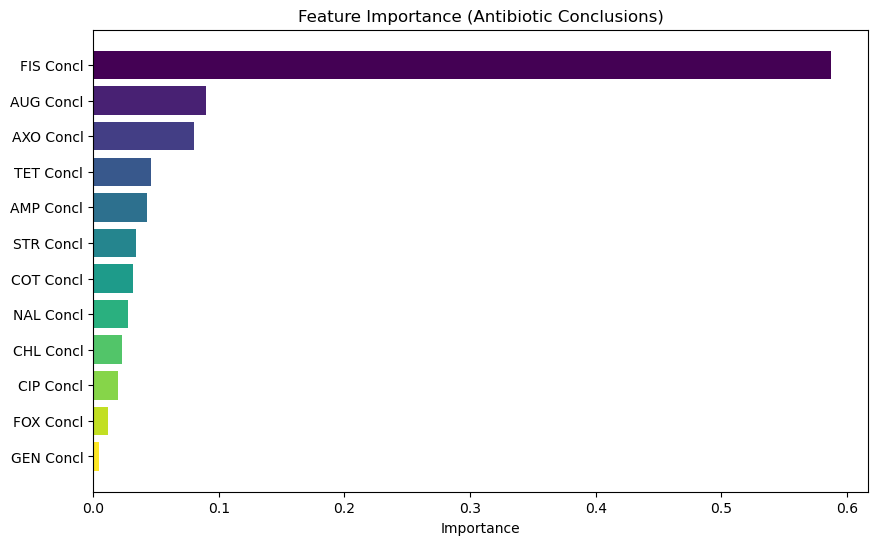

In [8]:
# Step 2: Create a new DataFrame with only AR Level > 0
df_positive_ar = df[df['AR Level'] > 0].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Step 3: Select the relevant features and target variable
features = df_positive_ar[['AMP Concl', 'AUG Concl', 'AXO Concl', 
                            'CHL Concl', 'CIP Concl', 'COT Concl', 
                            'FIS Concl', 'FOX Concl', 'GEN Concl', 
                            'NAL Concl', 'STR Concl', 'TET Concl']]

# Prepare the feature set and target variable
X = features
y = df_positive_ar['AR Level']

# In[7]:
# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In[8]:
# Step 5: Initialize and train the Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# In[9]:
# Step 6: Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Get feature importance
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# In[10]:
# Display feature importance
print("\nFeature Importance:")
print(importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=plt.cm.viridis(np.linspace(0, 1, len(importance_df))))
plt.xlabel('Importance')
plt.title('Feature Importance (Antibiotic Conclusions)')
plt.gca().invert_yaxis()  # Invert y axis to have the most important features at the top
plt.show()

## Forecasting
> The Exponential Smoothing model was used to forecast AR levels for the next five years, with the results visualized alongside historical data.
>
> Holt's Method was also applied for comparison, generating additional forecasts.

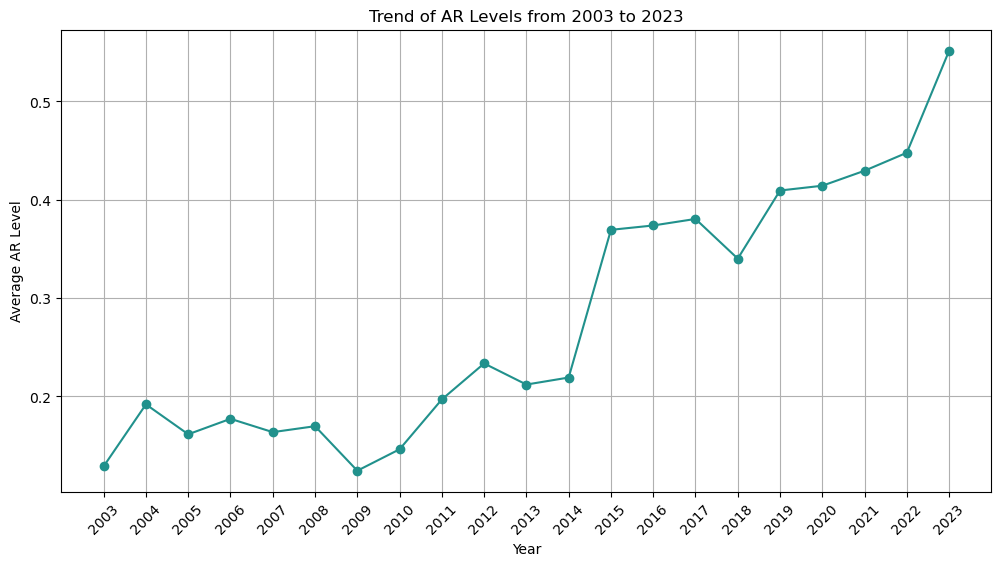

In [9]:
# Create a new DataFrame with only the Year and AR Level columns, aggregating by year
df_ar_level = df.groupby('Year')['AR Level'].mean().reset_index()

# Visualizing the AR Level trend from 2003 to 2023
plt.figure(figsize=(12, 6))
plt.plot(df_ar_level['Year'], df_ar_level['AR Level'], marker='o', color=plt.cm.viridis(0.5))  # Using Viridis color
plt.title('Trend of AR Levels from 2003 to 2023')
plt.xlabel('Year')
plt.ylabel('Average AR Level')
plt.xticks(df_ar_level['Year'], rotation=45)
plt.grid()
plt.show()


In [10]:
# Step 4: Fit the Exponential Smoothing model
exponential_model = ExponentialSmoothing(df_ar_level['AR Level'], trend='add', seasonal=None)
exponential_fit = exponential_model.fit()

# Forecast the next 5 years using Exponential Smoothing
exp_forecast_values = exponential_fit.forecast(steps=5)

# Create a DataFrame for the Exponential Smoothing forecast
exp_forecast_df = pd.DataFrame({'Year': np.arange(2024, 2029), 'AR Level Forecast': exp_forecast_values})
exp_forecast_df.set_index('Year', inplace=True)


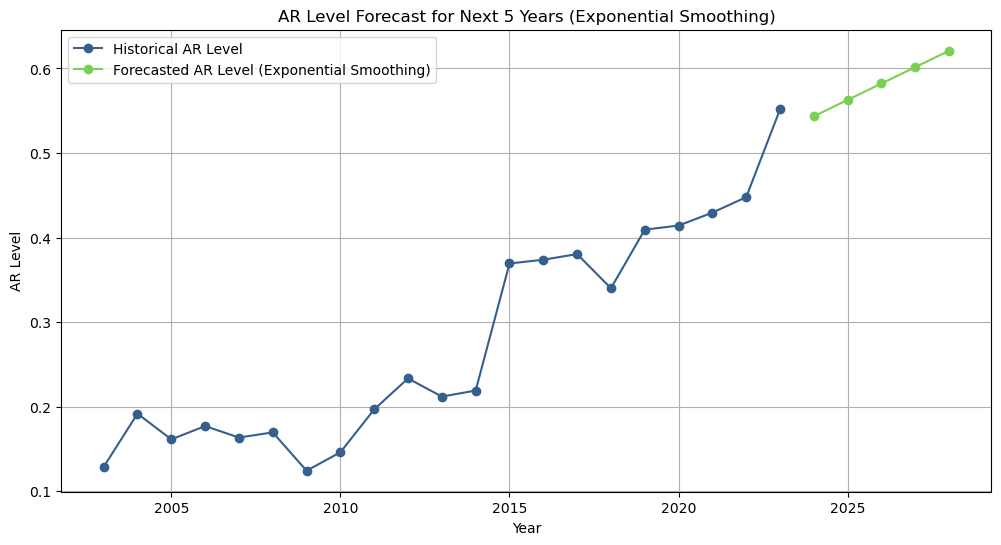


Forecasted Values for the Next 5 Years (Exponential Smoothing):


,AR Level Forecast
Year,
2024,0.543470
2025,0.562847
2026,0.582225
2027,0.601602
2028,0.620979


In [11]:
# Step 4: Fit the Exponential Smoothing model
exponential_model = ExponentialSmoothing(df_ar_level['AR Level'], trend='add', seasonal=None)
exponential_fit = exponential_model.fit()

# Forecast the next 5 years using Exponential Smoothing
exp_forecast_values = exponential_fit.forecast(steps=5)

# Create a DataFrame for the Exponential Smoothing forecast
exp_forecast_df = pd.DataFrame({'Year': np.arange(2024, 2029), 'AR Level Forecast': exp_forecast_values})
exp_forecast_df.set_index('Year', inplace=True)

# In[14]:
# Visualizing the historical data along with the Exponential Smoothing forecast
plt.figure(figsize=(12, 6))
plt.plot(df_ar_level['Year'], df_ar_level['AR Level'], label='Historical AR Level', marker='o', color=plt.cm.viridis(0.3))
plt.plot(exp_forecast_df.index, exp_forecast_df['AR Level Forecast'], label='Forecasted AR Level (Exponential Smoothing)', marker='o', color=plt.cm.viridis(0.8))
plt.title('AR Level Forecast for Next 5 Years (Exponential Smoothing)')
plt.xlabel('Year')
plt.ylabel('AR Level')
plt.legend()
plt.grid()
plt.show()

# Print the forecasted values from the Exponential Smoothing model
print("\nForecasted Values for the Next 5 Years (Exponential Smoothing):")
exp_forecast_df

In [12]:
# Split the data into training and testing sets for historical analysis
train_size = int(len(df_ar_level) * 0.8)  # Use 80% of the data for training
train, test = df_ar_level[:train_size], df_ar_level[train_size:]

# Fit the Exponential Smoothing model on the training data
exponential_model = ExponentialSmoothing(train['AR Level'], trend='add', seasonal=None)
exponential_fit = exponential_model.fit()

# Generate forecasts for the length of the test set
test_steps = len(test)
exp_forecast_values = exponential_fit.forecast(steps=test_steps)

# Create a DataFrame for the Exponential Smoothing forecast on historical data
exp_forecast_df = pd.DataFrame({'Year': test['Year'], 'AR Level Forecast': exp_forecast_values})
exp_forecast_df.set_index('Year', inplace=True)

# Calculate error metrics
comparison_df = exp_forecast_df.join(test.set_index('Year'), lsuffix='_Forecast', rsuffix='_Actual')

# Calculate error metrics
comparison_df['Absolute Error'] = (comparison_df['AR Level Forecast'] - comparison_df['AR Level']).abs()
comparison_df['Squared Error'] = (comparison_df['AR Level Forecast'] - comparison_df['AR Level']) ** 2

# Metrics
mae = comparison_df['Absolute Error'].mean()
mse = comparison_df['Squared Error'].mean()
rmse = mse ** 0.5
mape = (comparison_df['Absolute Error'] / comparison_df['AR Level']).mean() * 100

# Print the comparison DataFrame and metrics
print("Comparison DataFrame:")
print(comparison_df)

print(f"\nMean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Comparison DataFrame:
      AR Level Forecast  AR Level  Absolute Error  Squared Error
Year                                                            
2019           0.367991  0.409429        0.041438       0.001717
2020           0.382357  0.414286        0.031928       0.001019
2021           0.396724  0.429553        0.032830       0.001078
2022           0.411090  0.447867        0.036777       0.001353
2023           0.425457  0.551622        0.126166       0.015918

Mean Absolute Error (MAE): 0.0538
Mean Squared Error (MSE): 0.0042
Root Mean Squared Error (RMSE): 0.0649
Mean Absolute Percentage Error (MAPE): 11.31%


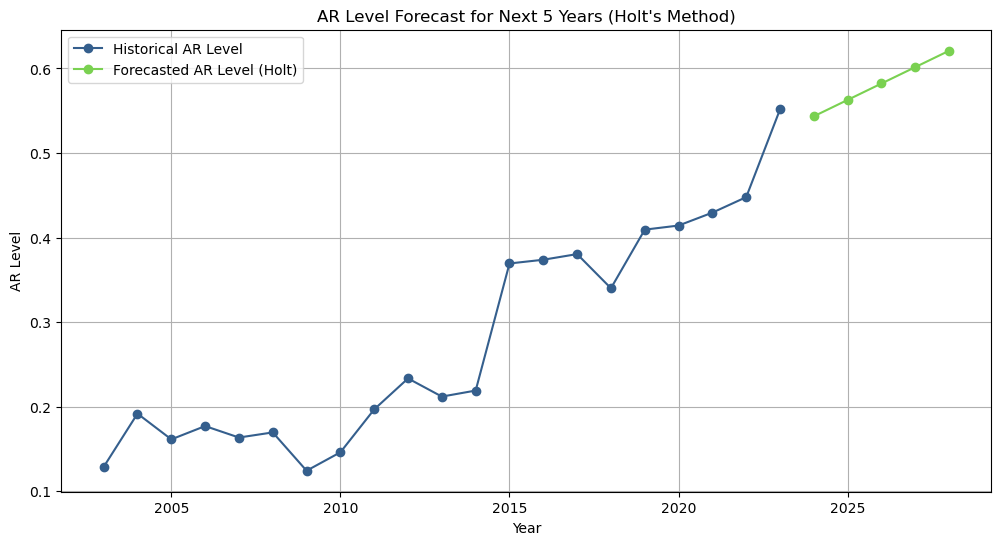


Holt's Forecast for the Next 5 Years:


,AR Level Forecast
Year,
2024,0.543470
2025,0.562847
2026,0.582225
2027,0.601602
2028,0.620979


In [13]:
# Fit the Holt’s Linear Trend Method model
holt_model = ExponentialSmoothing(df_ar_level['AR Level'], trend='add', seasonal=None)
holt_fit = holt_model.fit()

# Forecast the next 5 years using Holt's Method
holt_forecast = holt_fit.forecast(steps=5)

# Create a DataFrame for the forecast
holt_forecast_df = pd.DataFrame({'Year': np.arange(2024, 2029), 'AR Level Forecast': holt_forecast})
holt_forecast_df.set_index('Year', inplace=True)

# Plot the historical data and the forecast using Viridis color palette
plt.figure(figsize=(12, 6))
plt.plot(df_ar_level['Year'], df_ar_level['AR Level'], label='Historical AR Level', marker='o', color=plt.cm.viridis(0.3))
plt.plot(holt_forecast_df.index, holt_forecast_df['AR Level Forecast'], label='Forecasted AR Level (Holt)', marker='o', color=plt.cm.viridis(0.8))
plt.title('AR Level Forecast for Next 5 Years (Holt\'s Method)')
plt.xlabel('Year')
plt.ylabel('AR Level')
plt.legend()
plt.grid()
plt.show()

# Display the forecasted values
print("\nHolt's Forecast for the Next 5 Years:")
holt_forecast_df

In [14]:
# Step 1: Fit the Holt’s Linear Trend Method model on the training data
holt_model_train = ExponentialSmoothing(train['AR Level'], trend='add', seasonal=None)
holt_fit_train = holt_model_train.fit()

# Step 2: Generate forecasts for the length of the test set using Holt's Method
holt_forecast_values = holt_fit_train.forecast(steps=len(test))

# Step 3: Create a DataFrame for the Holt’s forecast on historical data
holt_forecast_df_test = pd.DataFrame({'Year': test['Year'], 'AR Level Forecast': holt_forecast_values})
holt_forecast_df_test.set_index('Year', inplace=True)

# Step 4: Calculate error metrics for Holt's Method
comparison_holt_df = holt_forecast_df_test.join(test.set_index('Year'), lsuffix='_Forecast', rsuffix='_Actual')

# Calculate error metrics
comparison_holt_df['Absolute Error'] = (comparison_holt_df['AR Level Forecast'] - comparison_holt_df['AR Level']).abs()
comparison_holt_df['Squared Error'] = (comparison_holt_df['AR Level Forecast'] - comparison_holt_df['AR Level']) ** 2

# Metrics for Holt's Method
mae_holt = comparison_holt_df['Absolute Error'].mean()
mse_holt = comparison_holt_df['Squared Error'].mean()
rmse_holt = mse_holt ** 0.5
mape_holt = (comparison_holt_df['Absolute Error'] / comparison_holt_df['AR Level']).mean() * 100

# Step 5: Print the comparison DataFrame and metrics for Holt's Method
print("\nHolt's Method Comparison DataFrame:")
print(comparison_holt_df)

print(f"\nMean Absolute Error (MAE) for Holt's Method: {mae_holt:.4f}")
print(f"Mean Squared Error (MSE) for Holt's Method: {mse_holt:.4f}")
print(f"Root Mean Squared Error (RMSE) for Holt's Method: {rmse_holt:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) for Holt's Method: {mape_holt:.2f}%")


Holt's Method Comparison DataFrame:
      AR Level Forecast  AR Level  Absolute Error  Squared Error
Year                                                            
2019           0.367991  0.409429        0.041438       0.001717
2020           0.382357  0.414286        0.031928       0.001019
2021           0.396724  0.429553        0.032830       0.001078
2022           0.411090  0.447867        0.036777       0.001353
2023           0.425457  0.551622        0.126166       0.015918

Mean Absolute Error (MAE) for Holt's Method: 0.0538
Mean Squared Error (MSE) for Holt's Method: 0.0042
Root Mean Squared Error (RMSE) for Holt's Method: 0.0649
Mean Absolute Percentage Error (MAPE) for Holt's Method: 11.31%


## Results Summary

> ### Random Forest Regressor
> - **Mean Squared Error (MSE)**: 0.03
> - **R-squared**: 0.98
>
> #### Feature Importance
> The most significant features in predicting antibiotic resistance levels are:
>
> | Feature   | Importance |
> |-----------|------------|
> | FIS Concl | 0.587327   |
> | AUG Concl | 0.089726   |
> | AXO Concl | 0.080394   |
> | TET Concl | 0.045979   |
> | AMP Concl | 0.042815   |
>
> ### Forecasting Results
> The AR level forecasts for the next five years are as follows:
>
> | Year | Forecasted AR Level |
> |------|----------------------|
> | 2024 | 0.543470             |
> | 2025 | 0.562847             |
> | 2026 | 0.582225             |
> | 2027 | 0.601602             |
> | 2028 | 0.620979             |
>
> ### Comparison of Forecasts
> The following table compares forecasted AR levels with actual values from 2019 to 2023:
> 
> | Year | Forecasted AR Level | Actual AR Level | Absolute Error |
> |------|----------------------|------------------|-----------------|
> | 2019 | 0.367991             | 0.409429         | 0.041438        |
> | 2020 | 0.382357             | 0.414286         | 0.031928        |
> | 2021 | 0.396724             | 0.429553         | 0.032830        |
> | 2022 | 0.411090             | 0.447867         | 0.036777        |
> | 2023 | 0.425457             | 0.551622         | 0.126166        |



## Conclusions
> The analysis demonstrates strong predictive capabilities for antibiotic resistance levels using the Random Forest model, achieving an R-squared value of 0.98 and a low Mean Squared Error (MSE) of 0.03. This indicates that the model can effectively explain the variability in antibiotic resistance. Additionally, the feature importance analysis highlights 'FIS Concl' as the most influential factor in predictions. The forecasts generated for AR levels over the next five years suggest an increasing trend, which is critical for anticipating future resistance patterns.
>


## Future Directions
> Incorporate Additional Features: Integrate more data attributes, such as geographical and demographic information related to Salmonella enteriditis cases. Understanding these factors can enhance the model's predictive power and provide insights into how environmental and social determinants impact resistance levels.
>
> Model Validation: Continuously validate the model against new data to ensure robustness and adaptability to changing resistance patterns. This is particularly important as antibiotic resistance evolves over time.
>
> Explore Advanced Algorithms: Consider employing machine learning techniques that capture complex relationships within the data, such as Gradient Boosting or Neural Networks. These methods may provide better predictions for Salmonella enteriditis resistance.
>
> Long-Term Trend Analysis: Investigate trends beyond 2028 using advanced forecasting methods to support public health planning. Monitoring antibiotic resistance trends in Salmonella enteriditis is crucial for developing targeted intervention strategies and informing policymakers on effective responses to outbreaks.